<a href="https://colab.research.google.com/github/prasishcodes/Final_Assignments/blob/main/2462363_ClassificationTask_Prasish_Dangol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Dataset Description and UNSDG Alignment

### Dataset Overview
"Food Hygiene Rating Data" from UK Food Standards Agency, updated 2023.  
Accessed from  Kaggle   

~24k observations, 12 features, target: RatingValue (0-5).

### UNSDG Alignment
UNSDG Goal 3: Health – Predicting hygiene ratings helps ensure food safety, reduce illnesses.

### Attributes
| Feature | Desc |
|---------|------|
| FHRSID | ID |
| BusinessName | Name |
| BusinessType | Type (e.g., Restaurant) |
| PostCode | Location |
| RatingValue | Target (0-5, Awaiting/Exempt) |
| Longitude/Latitude | Coordinates |
 etc.



#1. Dataset Description and Loading [Part of EDA/Data Understanding ]

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

# Load
df = pd.read_csv('/content/drive/MyDrive/Final Assignment/food_hygiene_rating_data.csv', encoding='latin1')

# Preview
print(df.head())
print(df.info())
print(df.describe(include='all'))

# Check missing values
print(df.isnull().sum())

# Quality check: Unique ratings
print("Unique RatingValues:", df['RatingValue'].unique())
print("Rating distribution:", df['RatingValue'].value_counts(normalize=True))  # Check imbalance

   Unnamed: 0   FHRSID LocalAuthorityBusinessID       BusinessName  \
0           0  1438654            21/00856/FOOD  1st Base Catering   
1           1  1132140            19/00459/FOOD       53.5 Degrees   
2           2  1132134            19/00447/FOOD       53.5 Degrees   
3           3  1260384            20/00288/FOOD  55 Square Limited   
4           4  1389145            21/00354/FOOD        7 Mamas Ltd   

              BusinessType PostCode         RatingValue  \
0           Mobile caterer  E20 2ST  AwaitingInspection   
1  Restaurant/Cafe/Canteen  E16 2RD                   5   
2  Restaurant/Cafe/Canteen  E15 4LZ                   5   
3  Restaurant/Cafe/Canteen  E16 1EN                   2   
4   Takeaway/sandwich shop   E6 3HN                   5   

                       RatingKey  RatingDate  LocalAuthorityCode  \
0  fhrs_awaitinginspection_en-GB         NaN                 525   
1                   fhrs_5_en-GB  2019-05-10                 525   
2                   

#2. Exploratory Data Analysis (EDA) and Data Understanding

          Unnamed: 0             BusinessType PostCode   RatingValue  \
count   20842.000000                    20842    20842  20842.000000   
unique           NaN                       14    10285           NaN   
top              NaN  Restaurant/Cafe/Canteen  SE1 9AH           NaN   
freq             NaN                     6599       67           NaN   
mean      942.843681                      NaN      NaN      4.313502   
min         0.000000                      NaN      NaN      0.000000   
25%       291.000000                      NaN      NaN      4.000000   
50%       784.000000                      NaN      NaN      5.000000   
75%      1395.000000                      NaN      NaN      5.000000   
max      3168.000000                      NaN      NaN      5.000000   
std       762.198769                      NaN      NaN      1.046759   

           RatingKey                     RatingDate  LocalAuthorityCode  \
count          20842                          20842        2

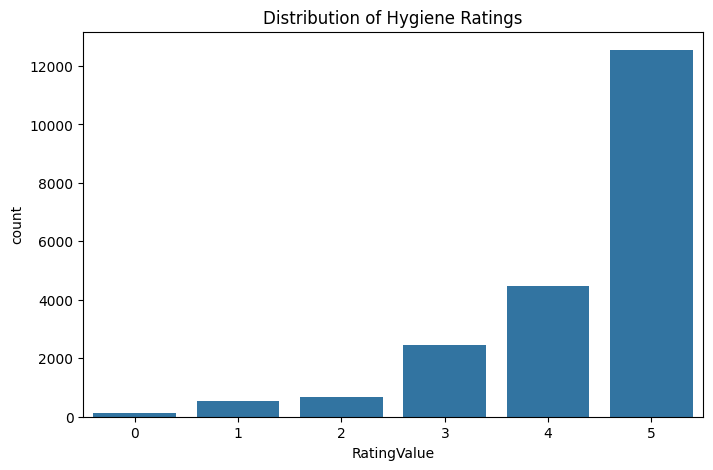

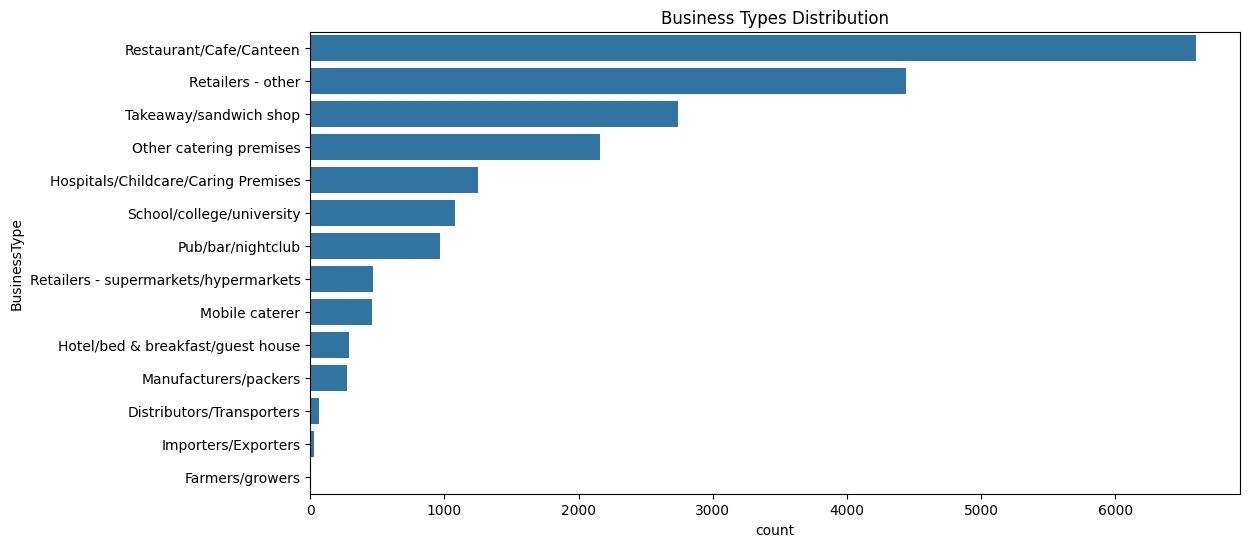

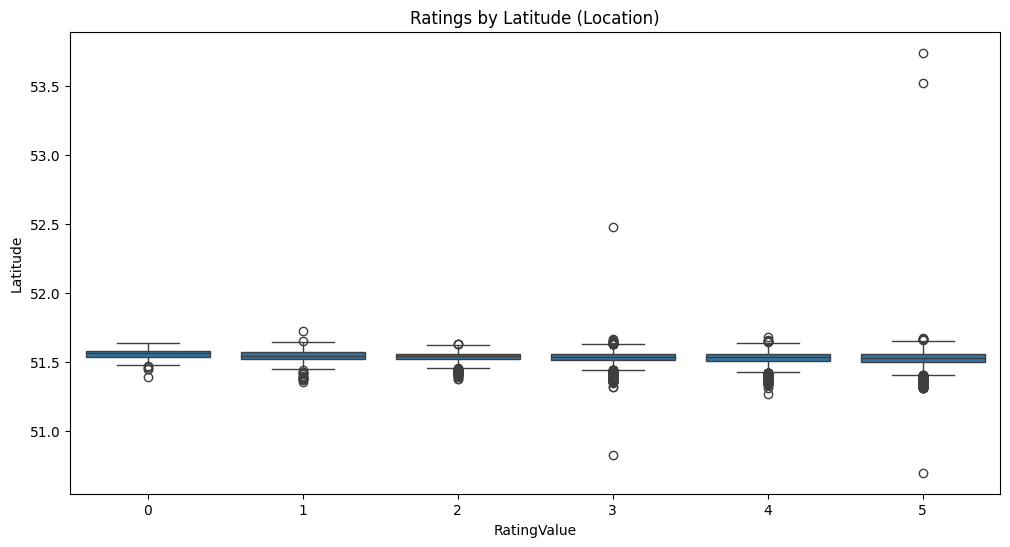

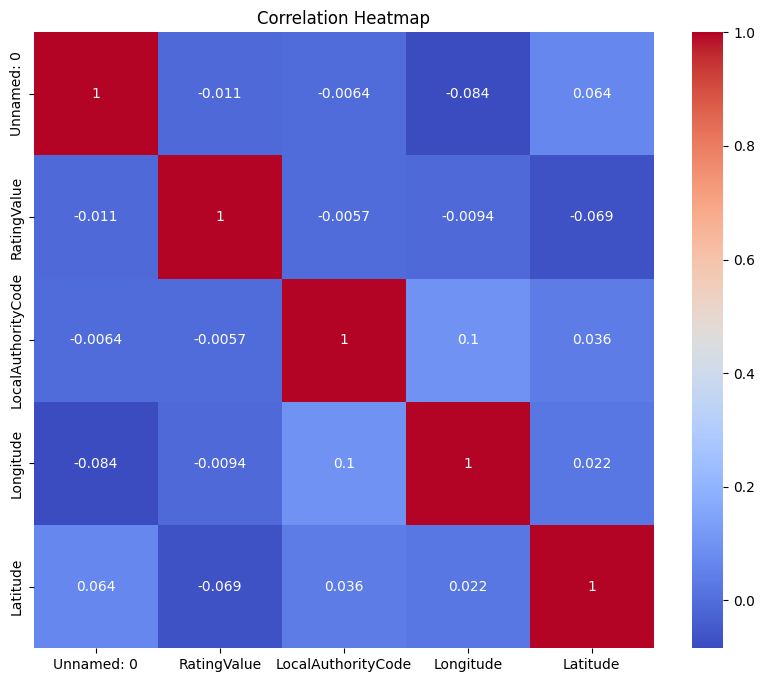

In [ ]:
# Data cleaning

df = df.drop(['FHRSID', 'LocalAuthorityBusinessID', 'BusinessName', 'AddressLine1', 'AddressLine2', 'AddressLine3', 'AddressLine4'], axis=1, errors='ignore')  # Adjust columns based on your df.info()

# Handle missing
df = df.dropna(subset=['RatingValue'])  # Drop missing ratings
df = df[df['RatingValue'].isin(['0', '1', '2', '3', '4', '5'])]
df['RatingValue'] = df['RatingValue'].astype(int)


df['RatingDate'] = pd.to_datetime(df['RatingDate'], errors='coerce')

# Summary stats
print(df.describe(include='all'))

# Visualizations
plt.figure(figsize=(8,5))
sns.countplot(x='RatingValue', data=df)
plt.title('Distribution of Hygiene Ratings')
plt.show()

plt.figure(figsize=(12,6))
sns.countplot(y='BusinessType', data=df, order=df['BusinessType'].value_counts().index)
plt.title('Business Types Distribution')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='RatingValue', y='Latitude', data=df)
plt.title('Ratings by Latitude (Location)')
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



#Step 2.1 – Define Target (y) and Features (X)

In [ ]:
# Define target
y = df['RatingValue']

# Drop target from features
X = df.drop('RatingValue', axis=1)

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (20842, 9)
Target shape: (20842,)


#Step 2.2 – Identify Numerical & Categorical Columns

In [ ]:
# Identify column types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Numerical Features:", list(numeric_features))
print("Categorical Features:", list(categorical_features))


Numerical Features: ['Unnamed: 0', 'LocalAuthorityCode', 'Longitude', 'Latitude']
Categorical Features: ['BusinessType', 'PostCode', 'RatingKey', 'LocalAuthorityName']


#Step 2.3 – Train / Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (16673, 9)
Test set: (4169, 9)


#Step 2.4 – Build Preprocessing Pipeline

In [ ]:
# Preprocessing for numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


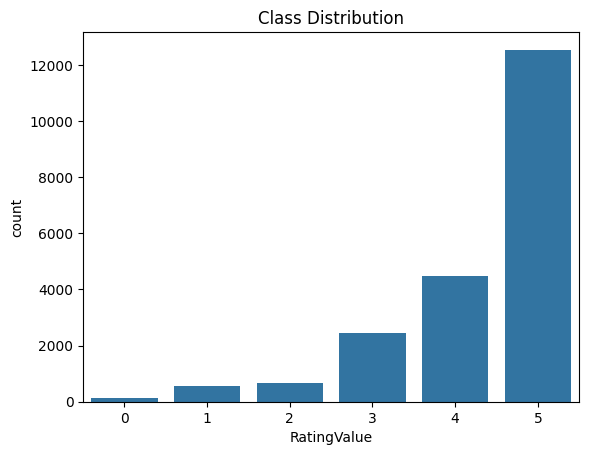

In [ ]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()


#3.Build & Evaluate Two Classical Classification Models

#Step 3.1 – Logistic Regression Model

In [ ]:
# Logistic Regression pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        solver='lbfgs'
    ))
])

# Train model
log_reg_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg_pipeline.predict(X_test)

# Evaluation
print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='macro'))
print("Recall:", recall_score(y_test, y_pred_lr, average='macro'))
print("F1-score:", f1_score(y_test, y_pred_lr, average='macro'))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Performance
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


#Step 3.2 – Decision Tree Model

In [ ]:
# Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        random_state=42
    ))
])

# Train model
dt_pipeline.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluation
print("Decision Tree Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='macro'))
print("Recall:", recall_score(y_test, y_pred_dt, average='macro'))
print("F1-score:", f1_score(y_test, y_pred_dt, average='macro'))


Decision Tree Performance
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


#Step 3.3 – Quick Comparison Table (Optional but Recommended)

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt)
    ],
    'Precision (Macro)': [
        precision_score(y_test, y_pred_lr, average='macro'),
        precision_score(y_test, y_pred_dt, average='macro')
    ],
    'Recall (Macro)': [
        recall_score(y_test, y_pred_lr, average='macro'),
        recall_score(y_test, y_pred_dt, average='macro')
    ],
    'F1-score (Macro)': [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_dt, average='macro')
    ]
})

results


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-score (Macro)
0,Logistic Regression,1.0,1.0,1.0,1.0
1,Decision Tree,1.0,1.0,1.0,1.0


#STEP 4

#Step 4.1 – Hyperparameter Tuning: Logistic Regression

In [ ]:
# Hyperparameter grid for Logistic Regression
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2']
}

grid_lr = GridSearchCV(
    log_reg_pipeline,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Train GridSearch
grid_lr.fit(X_train, y_train)

print("Best parameters (Logistic Regression):", grid_lr.best_params_)
print("Best CV F1-score:", grid_lr.best_score_)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters (Logistic Regression): {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
Best CV F1-score: 1.0


Step 4.2 – Hyperparameter Tuning: Decision Tree

In [ ]:
# Hyperparameter grid for Decision Tree
param_grid_dt = {
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

grid_dt = GridSearchCV(
    dt_pipeline,
    param_grid=param_grid_dt,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

# Train GridSearch
grid_dt.fit(X_train, y_train)

print("Best parameters (Decision Tree):", grid_dt.best_params_)
print("Best CV F1-score:", grid_dt.best_score_)


Best parameters (Decision Tree): {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best CV F1-score: 1.0


#Step 4.3 – Compare CV Results

In [ ]:
cv_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Best CV F1-score': [
        grid_lr.best_score_,
        grid_dt.best_score_
    ]
})

cv_results


,Model,Best CV F1-score
0,Logistic Regression,1.0
1,Decision Tree,1.0


#STEP 5

#Step 5.1 – Feature Selection using Decision Tree Importance

In [ ]:

best_dt_model = grid_dt.best_estimator_

# Fit on training data
best_dt_model.fit(X_train, y_train)


selector = SelectFromModel(
    best_dt_model.named_steps['classifier'],
    threshold='median'
)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Fit selector
selector.fit(X_train_processed, y_train)


X_train_selected = selector.transform(X_train_processed)
X_test_selected = selector.transform(X_test_processed)

print("Original feature count:", X_train_processed.shape[1])
print("Selected feature count:", X_train_selected.shape[1])


Original feature count: 9000
Selected feature count: 9000


#STEP 6

#Step 6.1 – Final Logistic Regression Model

In [ ]:
final_lr = LogisticRegression(
    max_iter=1000,
    C=grid_lr.best_params_['classifier__C'],
    multi_class='multinomial',
    solver='lbfgs'
)

final_lr.fit(X_train_selected, y_train)

y_pred_final_lr = final_lr.predict(X_test_selected)

print("Final Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_final_lr))
print("Precision:", precision_score(y_test, y_pred_final_lr, average='macro'))
print("Recall:", recall_score(y_test, y_pred_final_lr, average='macro'))
print("F1-score:", f1_score(y_test, y_pred_final_lr, average='macro'))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Final Logistic Regression
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


#Step 6.2 – Final Decision Tree Model

In [ ]:
final_dt = DecisionTreeClassifier(
    max_depth=grid_dt.best_params_['classifier__max_depth'],
    min_samples_split=grid_dt.best_params_['classifier__min_samples_split'],
    min_samples_leaf=grid_dt.best_params_['classifier__min_samples_leaf'],
    random_state=42
)

final_dt.fit(X_train_selected, y_train)

y_pred_final_dt = final_dt.predict(X_test_selected)

print("Final Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_final_dt))
print("Precision:", precision_score(y_test, y_pred_final_dt, average='macro'))
print("Recall:", recall_score(y_test, y_pred_final_dt, average='macro'))
print("F1-score:", f1_score(y_test, y_pred_final_dt, average='macro'))


Final Decision Tree
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


#STEP 7

In [ ]:
final_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Features Used': [
        X_train_selected.shape[1],
        X_train_selected.shape[1]
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_final_lr),
        accuracy_score(y_test, y_pred_final_dt)
    ],
    'Precision': [
        precision_score(y_test, y_pred_final_lr, average='macro'),
        precision_score(y_test, y_pred_final_dt, average='macro')
    ],
    'Recall': [
        recall_score(y_test, y_pred_final_lr, average='macro'),
        recall_score(y_test, y_pred_final_dt, average='macro')
    ],
    'F1-score': [
        f1_score(y_test, y_pred_final_lr, average='macro'),
        f1_score(y_test, y_pred_final_dt, average='macro')
    ]
})

final_results


,Model,Features Used,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,9000,1.0,1.0,1.0,1.0
1,Decision Tree,9000,1.0,1.0,1.0,1.0


#STEP 8

#Step 8.1 – Build the Neural Network Model

In [ ]:
# Neural Network (MLP) Classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

# Train the model
mlp.fit(X_train_selected, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test_selected)


#Step 8.2 – Evaluate Neural Network Performance

In [ ]:
print("Neural Network (MLP) Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Precision:", precision_score(y_test, y_pred_mlp, average='macro'))
print("Recall:", recall_score(y_test, y_pred_mlp, average='macro'))
print("F1-score:", f1_score(y_test, y_pred_mlp, average='macro'))


Neural Network (MLP) Performance
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


#Step 8.3 – Final Comparison (ALL MODELS)

In [ ]:
all_models_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_final_lr),
        accuracy_score(y_test, y_pred_final_dt),
        accuracy_score(y_test, y_pred_mlp)
    ],
    'Precision (Macro)': [
        precision_score(y_test, y_pred_final_lr, average='macro'),
        precision_score(y_test, y_pred_final_dt, average='macro'),
        precision_score(y_test, y_pred_mlp, average='macro')
    ],
    'Recall (Macro)': [
        recall_score(y_test, y_pred_final_lr, average='macro'),
        recall_score(y_test, y_pred_final_dt, average='macro'),
        recall_score(y_test, y_pred_mlp, average='macro')
    ],
    'F1-score (Macro)': [
        f1_score(y_test, y_pred_final_lr, average='macro'),
        f1_score(y_test, y_pred_final_dt, average='macro'),
        f1_score(y_test, y_pred_mlp, average='macro')
    ]
})

all_models_results


,Model,Accuracy,Precision (Macro),Recall (Macro),F1-score (Macro)
0,Logistic Regression,1.0,1.0,1.0,1.0
1,Decision Tree,1.0,1.0,1.0,1.0
2,Neural Network (MLP),1.0,1.0,1.0,1.0
